# Demo for Urban Topic Modeling

Yongha Hwang, PhD, University of Michigan Medical School

In [69]:
import json
import requests
import pandas as pd
from collections import Counter

from datashader.utils import lnglat_to_meters as webm
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import colormap_select, Greys9
from colorcet import fire
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from gensim import corpora, models, similarities

import warnings
warnings.filterwarnings('ignore')

import pyLDAvis.gensim
import pyLDAvis

%matplotlib inline

## Get OpenStreetMap Tags

#### region of interest

We are going to use the Greater London's data for this notebook

#### keys of interest
From osm dataset, we will extract elements (key:value pairs) whose key is within [amenity, craft, historic, leisure, 
office, shop, sport, tourism]. Some of the elements are nodes(point) and others are closed ways(polygon) like building. When an element is way type, we will use its centroid.

#### Overpass API
We are going to use overpass API to extract osm data

In [16]:
# keys of interest
poi_keys = ["amenity", 
            "craft",
            "historic",
            "leisure",
            "office",
            "shop",
            "sport",
            "tourism"
           ]

# region of interest
bbox_string = '51.199,-0.602,51.744,0.374'
timeout = 3600

In [35]:
# a function creating the key query
def key_query(element_type, keys):
    query = ""
    for key in poi_keys:
        query += element_type + "[\""
        query += key
        query += "\"];"
    query = "(" + query + ")"
    return query

In [33]:
# a function getting osm data through overpass api
def get_osm(query):
    r = requests.post(
        "https://overpass-api.de/api/interpreter",
        data={"data": query},
        timeout=1800,
        headers={'Accept-Charset': 'utf-8;q=0.7,*;q=0.7'}
    )
    r.encoding = 'utf-8'
    return(json.loads(r.text))

### Import node elements

In [36]:
%%time
node_query = '[out:json][timeout:{}][bbox:{}];{};out;'.format(
    timeout, bbox_string, key_query("node", poi_keys))
nodes = get_osm(node_query)
# check the number of nodes
print(len(nodes['elements']))

77000
CPU times: user 723 ms, sys: 147 ms, total: 870 ms
Wall time: 32.3 s


In [24]:
# convert node into dataframe
node_df = pd.DataFrame(nodes['elements'])
node_df.head()

,id,lat,lon,tags,type
0,1,51.477948,-0.001486,"{'historic': 'memorial', 'memorial': 'stone', ...",node
1,108042,51.523536,-0.135529,"{'addr:housenumber': '31', 'addr:postcode': 'W...",node
2,108539,51.529125,-0.093388,"{'amenity': 'bicycle_rental', 'capacity': '24'...",node
3,109575,51.528262,-0.143121,"{'amenity': 'advice', 'name': 'Citizens advice...",node
4,110075,51.534257,-0.140276,"{'amenity': 'bicycle_parking', 'capacity': '2'}",node


### Import way elements

In [40]:
%%time
# get data from overpass
way_query = '[out:json][timeout:{}][bbox:{}];{};out;'.format(
    timeout, bbox_string, key_query("way", poi_keys))
subnode_query = '[out:json][timeout:{}][bbox:{}];{};(>;);out;'.format(
    timeout, bbox_string, key_query("way", poi_keys))

# get data
ways = get_osm(way_query)
ways_subnodes = get_osm(subnode_query)

[out:json][timeout:3600][bbox:51.199,-0.602,51.744,0.374];(way["amenity"];way["craft"];way["historic"];way["leisure"];way["office"];way["shop"];way["sport"];way["tourism"];);out;
[out:json][timeout:3600][bbox:51.199,-0.602,51.744,0.374];(way["amenity"];way["craft"];way["historic"];way["leisure"];way["office"];way["shop"];way["sport"];way["tourism"];);(>;);out;
CPU times: user 479 µs, sys: 1.13 ms, total: 1.61 ms
Wall time: 888 µs


#### add centroid info

In [27]:
node_coord = dict()
for node in ways_subnodes['elements']:
    node_coord[node['id']] = node

# function getting nodes' center
def nodes_center(nodes):
    lat_sum = 0
    lon_sum = 0
    for node_id in nodes:
        node = node_coord[node_id]
        lat_sum += node['lat']
        lon_sum += node['lon']
    return {'lat':lat_sum/len(nodes), 'lon':lon_sum/len(nodes)}

for way in ways['elements']:
    coords = nodes_center(way['nodes'])
    way['lat'] = coords['lat']
    way['lon'] = coords['lon']

way_df = pd.DataFrame(ways['elements'])[['id', 'lat', 'lon', 'tags', 'type']]
way_df.head()

,id,lat,lon,tags,type
0,28303,51.383864,-0.421414,"{'access': 'customers', 'amenity': 'parking', ...",way
1,75215,51.382862,-0.429840,{'amenity': 'parking'},way
2,1080949,51.376494,-0.473800,"{'access': 'permissive', 'amenity': 'parking',...",way
3,2472983,51.282005,-0.327096,"{'alt_name': 'Dorking Road', 'highway': 'trunk...",way
4,2523716,51.242234,-0.209662,"{'highway': 'residential', 'historic': '1999',...",way


### Merge nodes and ways, create term column, and clean up

In [ ]:
# merge two dataframes
df = pd.concat([node_df, way_df])
df = df.reset_index(drop=True)

# add projected coords
df = df.assign(easting = lambda x: webm(x.lon, x.lat)[0])
df = df.assign(northing = lambda x: webm(x.lon, x.lat)[1])


# add term list column
remove_values = ["parking", "post_box", "yes"]

def make_terms(row):
    terms = list()
    for key in row.tags:
        if key in inc_keys:
            term = row.tags[key]
            if ";" in term:
                for subterm in term.split(";"):
                    if subterm.strip() not in remove_values:
                        terms.append(subterm.strip())
            else:
                if term.strip() not in remove_values:
                    terms.append(term.strip())
    return terms

df['terms'] = df.apply(make_terms, axis=1)

# remove empty row
df = df[df.terms.str.len() > 0]

df.head()

In [ ]:
# save as pickle
df.to_pickle("../dataset/london.pickle")

In [43]:
# load from pickle
df = pd.read_pickle("../dataset/london.pickle")

### Plotting with DataShader

119545


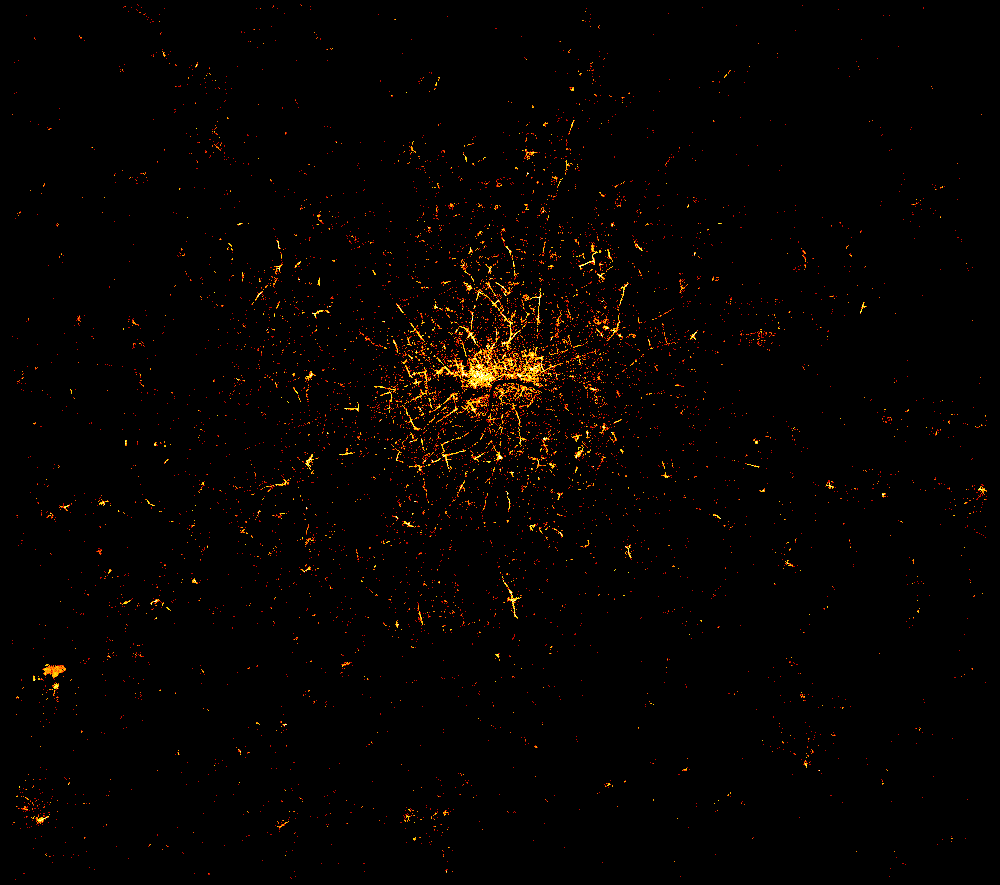

In [45]:
img_ratio = (max(df.northing)-min(df.northing))/(max(df.easting) - min(df.easting))
plot_width = 1000
cvs = ds.Canvas(plot_width=plot_width, plot_height=int(plot_width*img_ratio))
agg = cvs.points(df, 'easting', 'northing')
img = tf.shade(agg, how='eq_hist', cmap=fire, min_alpha=10)
img = tf.set_background(img, "black")
print(len(df))
img

## "Word" Frequency

1471


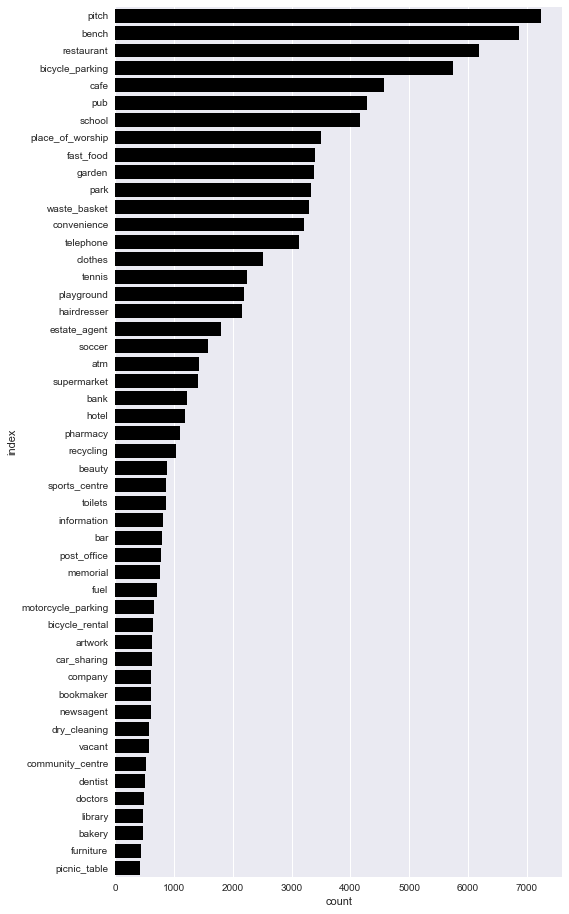

In [54]:
words = list()
def get_word(row):
    for term in row.terms:
        words.append(term)
df.apply(get_word, axis=1)

words_counts = Counter(words)
wdf = pd.DataFrame.from_dict(words_counts, orient='index').rename(columns={0:"count"})
print(len(wdf))
wdf50 = wdf.sort_values(["count"], ascending=False).head(50)
wdf50 = wdf50.reset_index()
plt.figure(figsize=(8, 16))
sns.set()
sns.barplot(y="index", x="count", color="black", data=wdf50);

## Topic Modeling

### Find Clusters

In [59]:
# dbscan parameters
epsilon = 60
min_pts = 9

db = DBSCAN(eps=epsilon, min_samples=min_pts).fit(df[['easting', 'northing']])
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("Number of clusters:{}".format(n_clusters_))
df['label'] = pd.Series(labels).values
print("Number of pois:{}".format(len(df[df.label>0])))

# print top 10 clusters
df[df.label>0][['id', 'label']].groupby('label').count().sort_values(['id'], ascending=False).head(10)

Number of clusters:1321
Number of pois:47751


,id
label,
8,3910
97,607
106,549
42,483
143,409
2,389
89,354
31,350
78,308


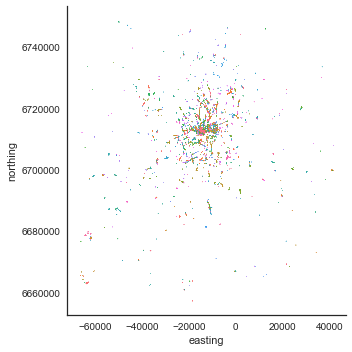

In [65]:
sns.set_style("white")
sns.lmplot('easting', 'northing', data=df[df.label>0], hue='label', fit_reg=False,  legend=False, scatter_kws={"s": 0.1})

###  LDA

In [67]:
cluster_poi = df[df.label>0].groupby('label')['terms'].apply(sum).tolist()
dictionary = corpora.Dictionary(cluster_poi)
# filter extreme words
dictionary.filter_extremes(no_below=20, no_above=0.3)
corpus = [dictionary.doc2bow(terms) for terms in cluster_poi]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [72]:
%%time
lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=100, 
                      eval_every=None, passes=1000, iterations=3000)

CPU times: user 20min 7s, sys: 9.73 s, total: 20min 17s
Wall time: 21min 11s


## Visualization

In [71]:
warnings.filterwarnings('ignore')
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/Users/yonghah/anaconda3/envs/datashader/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-10-19 11:07:15.517731. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
22     24.386132        1       1  0.101552 -0.015378
43     13.371769        1       2 -0.342655 -0.240862
21      4.196224        1       3  0.257099 -0.154186
41      4.184029        1       4  0.146826 -0.172776
37      3.739014        1       5 -0.025875 -0.096906
11      3.583774        1       6  0.126194 -0.036480
27      3.517431        1       7 -0.147642  0.025253
45      3.496397        1       8  0.173535 -0.192788
13      3.417916        1       9  0.195083 -0.099528
28      2.786412        1      10 -0.048971 -0.133079
32      2.700601        1      11  0.119989  0.007684
31      1.849622        1      12  0.064454  0.074357
17      1.778905        1      13  0.147961 -0.016309
23      1.752135        1      14  0.182394 -0.088516
6       1.566988        1      15  0.143931  0.026047
8       1.521893        1      16  0.107173 -0.077000
40      1.447114        1      17  0.070507 -0.048208
30      1.446221        1      18 -0.240042 -0.168006
44      1.256570        1      19  0.013852  0.004833
10      1.237358        1      20 -0.273420 -0.135200
15      1.219116        1      21 -0.142954 -0.144863
48      1.208763        1      22  0.074180  0.011175
25      1.129165        1      23  0.004375 -0.035136
39      1.036692        1      24  0.013172  0.020840
49      0.965319        1      25  0.085713  0.114043
46      0.941925        1      26  0.035135  0.146576
4       0.907903        1      27 -0.052934  0.064659
33      0.887395        1      28 -0.264715 -0.119159
18      0.838001        1      29 -0.058997  0.097892
38      0.713863        1      30  0.001904  0.049800
2       0.615856        1      31  0.070761  0.002174
29      0.607640        1      32  0.111939 -0.070665
9       0.587894        1      33 -0.079082  0.154098
36      0.503743        1      34  0.067038 -0.019807
16      0.436427        1      35 -0.060081  0.138016
5       0.430375        1      36 -0.103552  0.125354
14      0.403717        1      37 -0.081890 -0.100715
19      0.401537        1      38  0.014904  0.027714
34      0.364990        1      39  0.032959 -0.005620
47      0.360689        1      40 -0.026281  0.112970
35      0.330721        1      41 -0.096550  0.123683
0       0.308425        1      42 -0.058957  0.106545
26      0.292915        1      43  0.033675  0.067503
42      0.269652        1      44  0.005064  0.092116
7       0.262411        1      45 -0.055605  0.164419
24      0.252004        1      46 -0.121606  0.067028
1       0.227951        1      47 -0.052565  0.061920
12      0.086136        1      48 -0.022332  0.094830
20      0.086136        1      49 -0.022332  0.094830
3       0.086136        1      50 -0.022332  0.094830, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
73    Default  1008.000000          garden  1008.000000  30.0000    30.00
52    Default  2092.000000           bench  2092.000000  29.0000    29.00
7     Default  1085.000000    waste_basket  1085.000000  28.0000    28.00
11    Default  1262.000000         clothes  1262.000000  27.0000    27.00
9     Default   292.000000         jewelry   292.000000  26.0000    26.00
2     Default   828.000000            bank   828.000000  25.0000    25.00
8     Default   210.000000      stationery   210.000000  24.0000    24.00
88    Default   158.000000          sports   158.000000  23.0000    23.00
77    Default   270.000000           hotel   270.000000  22.0000    22.00
64    Default   397.000000          vacant   397.000000  21.0000    21.00
55    Default   206.000000           books   206.000000  20.0000    20.00
91    Default   171.000000    picnic_table   171.000000  19.0000    19.00
53    Default   256.000000       recycling   256.000000  18.0000    18.00
42    Default   294.000000       furnit